In [100]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
@njit
def simulate_diffusion(v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates one realization of the diffusion process given
    a set of parameters and a step size `dt`.

    Parameters:
    -----------
    v     : float
        The drift rate (rate of information uptake)
    a     : float
        The boundary separation (decision threshold).
    beta  : float in [0, 1]
        Relative starting point (prior option preferences)
    tau   : float
        Non-decision time (additive constant)
    dt    : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process. Not considered
        a parameter and typically fixed to either 1.0 or 0.1.
    max_time: float, optional (default: .10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    (x, c) - a tuple of response time (y - float) and a 
        binary decision (c - int) 
    """

    # Inits (process starts at relative starting point)
    y = beta * a
    num_steps = tau
    const = scale*np.sqrt(dt)

    # Loop through process and check boundary conditions
    while (y <= a and y >= 0) and num_steps <= max_time:

        # Perform diffusion equation
        z = np.random.randn()
        y += v*dt + const*z

        # Increment step counter
        num_steps += dt

    if y >= a:
        c = 1.
    else:
        c = 0.
    return (round(num_steps, 3), c)


@njit
def simulate_diffusion_n(num_sims, v, a, beta, tau, dt=1e-3, scale=1.0, max_time=10.):
    """
    Simulates multiple instances of the drift-diffusion process for a given
    number of simulations. It leverages the `simulate_diffusion` function.

    Parameters:
    -----------
    num_sims : int
        The number of simulations to perform.
    v        : float
        The drift rate (rate of information uptake).
    a        : float
        The boundary separation (decision threshold).
    beta     : float in [0, 1]
        Relative starting point (prior option preferences).
    tau      : float
        Non-decision time (additive constant).
    dt       : float, optional (default: 1e-3 = 0.001)
        The step size for the Euler algorithm.
    scale    : float, optional (default: 1.0)
        The scale (sqrt(var)) of the Wiener process.
    max_time : float, optional (default: 10)
        The maximum number of seconds before forced termination.

    Returns:
    --------
    data : np.ndarray of shape (num_sims, 2)
        An array containing the response times and decisions for each simulation.
        Column 0 contains response times, and column 1 contains binary decisions (1 for upper boundary, 0 for lower).
    """

    data = np.zeros((num_sims, 2))
    for n in range(num_sims):
        data[n, :] = simulate_diffusion(v, a, beta, tau, dt, scale, max_time)
    return data

def visualize_diffusion_model(data, figsize=(8,6)):
    """
    Visualizes the results of multiple drift-diffusion simulations. The function
    creates a histogram of response times separated by decision correctness.

    Parameters:
    -----------
    data    : np.ndarray of shape (N, 2)
        Simulation data where N is the number of simulations. The first column
        contains response times, and the second column contains binary decisions.
    figsize : tuple, optional (default: (8, 6))
        The size of the resulting figure.

    Returns:
    --------
    f : matplotlib.figure.Figure
        The figure object containing the plot.
    """
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    sns.histplot(data[:, 0][data[:, 1] == 1], color='maroon', ax=ax, label='Correct responses')
    sns.histplot(data[:, 0][data[:, 1] == 0], color='grey', ax=ax, label='Incorrect responses')
    sns.despine(ax=ax)
    ax.set_xlabel('Response time (s)', fontsize="20")
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.legend(fontsize="20")
    return f

## Question 1: Differences in Means of RT Distributions for Different Drift Rates

We investigate how varying the drift rate (`v`) affects the means of RT distributions by simulating the DDM with drift rates in the range [0.5, 1.5], generating 2000 synthetic observations for each rate.

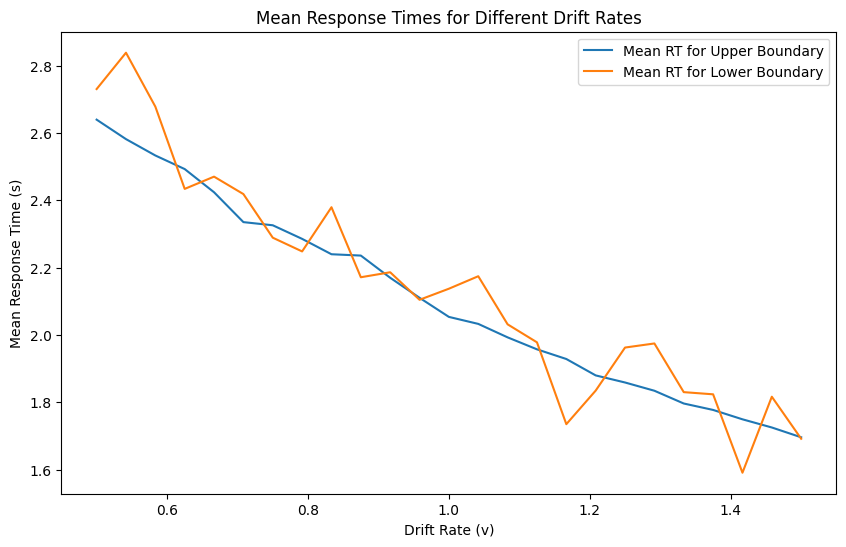

In [102]:
# Generate data for varying drift rates
drift_rates = np.linspace(0.5, 1.5, 25)
mean_rts = []
for v in drift_rates:
    data = simulate_diffusion_n(2000, v, a=3, beta=0.5, tau=0.7)
    mean_upper = np.mean(data[:, 0][data[:, 1] == 1])
    mean_lower = np.mean(data[:, 0][data[:, 1] == 0])
    mean_rts.append((v, mean_upper, mean_lower))

mean_rts = np.array(mean_rts)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(mean_rts[:, 0], mean_rts[:, 1], label='Mean RT for Upper Boundary')
plt.plot(mean_rts[:, 0], mean_rts[:, 2], label='Mean RT for Lower Boundary')
plt.xlabel('Drift Rate (v)')
plt.ylabel('Mean Response Time (s)')
plt.title('Mean Response Times for Different Drift Rates')
plt.legend()
plt.show()

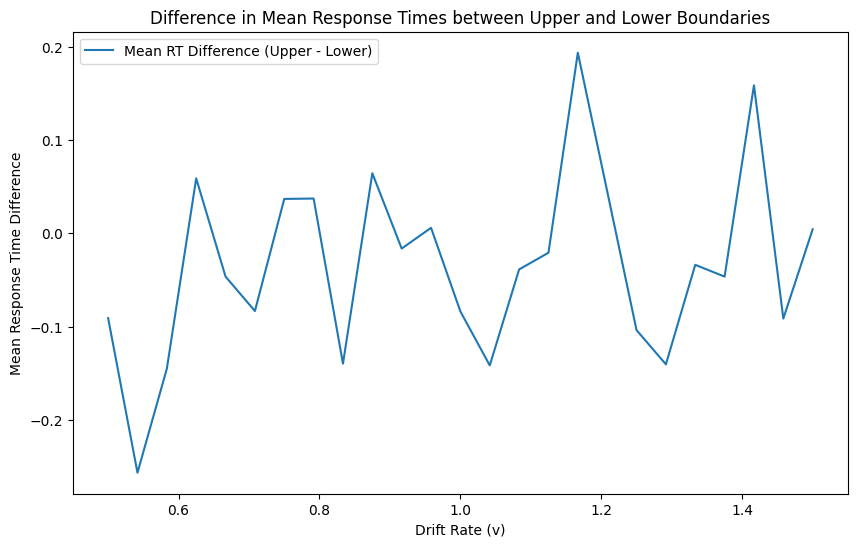

In [103]:
# Calculate the difference in mean response times
mean_rt_difference = mean_rts[:, 1] - mean_rts[:, 2]

# Plot the mean response time difference
plt.figure(figsize=(10, 6))
plt.plot(mean_rts[:, 0], mean_rt_difference, label='Mean RT Difference (Upper - Lower)')
plt.xlabel('Drift Rate (v)')
plt.ylabel('Mean Response Time Difference')
plt.title('Difference in Mean Response Times between Upper and Lower Boundaries')
plt.legend()
plt.show()

### Observations and Interpretation

Upon analysis of the mean RTs for both the lower and upper boundaries, we observed the following:
- The mean RT for the upper boundary decreases as the drift rate increases, which is in line with the model's prediction that higher drift rates lead to faster information accumulation and quicker decisions toward the upper boundary.
- Similarly, for the lower boundary, mean RTs also decrease as the drift rate increases, as depicted in the graph. 
- Since a difference greater than 0 indicates higher upper mrt and less than 0 indicates higher lower mrt, we see the evident fluctuation. The lower bound mrt is more prominent overall, with occassional spikes resulting in higher upper bound mrt.

This suggests that higher drift rates facilitate faster decision-making processes towards both boundaries. However, while both upper and lower boundaries exhibit a decrease in mean RTs with increasing drift rates, the rate of decrease differs and is more inconsistent with the lower boundary, indicating potential differences in decision dynamics between the two boundaries.

## Question 2: Effects of Other Parameters on RT Distributions

We now explore how other DDM parameters (boundary separation `a`, starting point `beta`, and non-decision time `tau`) influence the means and standard deviations of the simulated RT distributions.

In [104]:
def analyze_parameter_impact_on_rts(param_values, param_name, fixed_params):
    """
    Analyzes the impact of varying a single parameter on the response times (RTs) 
    in the drift-diffusion model. This function computes the mean and standard deviation
    of RTs for both decision boundaries (upper and lower) across a range of values for 
    the specified parameter.

    Parameters:
    -----------
    param_values : np.ndarray
        An array of values for the parameter to be varied.
    param_name   : str
        The name of the parameter to be varied.
    fixed_params : dict
        A dictionary of other fixed parameters of the drift-diffusion model.

    Returns:
    --------
    results : np.ndarray
        A 2D array with shape (len(param_values), 4). Each row corresponds to a different 
        value of the varied parameter, and the four columns represent the mean and standard 
        deviation of RTs for the upper boundary (first two columns) and the lower boundary 
        (last two columns).
    """

    # Initialize results array
    results = np.zeros((len(param_values), 4))
    
    # Run simulations for each parameter value
    for i, value in enumerate(param_values):
        # Update the varying parameter
        params = {**fixed_params, param_name: value}

        # Simulate and get data
        data = simulate_diffusion_n(2000, **params)

        # Compute statistics
        mean_upper = np.mean(data[data[:, 1] == 1, 0])
        std_upper = np.std(data[data[:, 1] == 1, 0])
        mean_lower = np.mean(data[data[:, 1] == 0, 0])
        std_lower = np.std(data[data[:, 1] == 0, 0])

        # Store results
        results[i, :] = mean_upper, std_upper, mean_lower, std_lower

    return results

def plot_stats(param_range, stats, param_name):
    """
    Plots the mean and standard deviation of response times (RTs) against a specified parameter. 
    This function generates three subplots: one for the mean RTs, one for the standard 
    deviations of RTs, and one for the differences in mean RTs between upper and lower boundaries.

    Parameters:
    -----------
    param_range : np.ndarray
        An array of values for the parameter that was varied during the simulations.
    stats       : np.ndarray
        A 2D array containing statistics of RTs. It has four columns, representing 
        the mean and standard deviation of RTs for the upper and lower boundaries.
    param_name  : str
        The name of the parameter that was varied, which will be used for labeling the plot.

    Returns:
    --------
    None
        The function produces a plot and does not return any value.
    """

    plt.figure(figsize=(16, 5))

    # Plotting Mean RTs
    plt.subplot(1, 3, 1)
    plt.plot(param_range, stats[:, 0], label='Upper Mean RT')
    plt.plot(param_range, stats[:, 2], label='Lower Mean RT')
    plt.title(f'Mean RT vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Mean RT')
    plt.legend()

    # Plotting Standard Deviations of RTs
    plt.subplot(1, 3, 2)
    plt.plot(param_range, stats[:, 1], label='Upper Std RT')
    plt.plot(param_range, stats[:, 3], label='Lower Std RT')
    plt.title(f'Std RT vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Std RT')
    plt.legend()

    # Calculate the difference in mean RTs
    mean_rt_difference = stats[:, 0] - stats[:, 2]

    # Plotting Mean RT Difference
    plt.subplot(1, 3, 3)
    plt.plot(param_range, mean_rt_difference, label='Mean RT Difference (Upper - Lower)')
    plt.title('Mean RT Difference vs ' + param_name)
    plt.xlabel(param_name)
    plt.ylabel('Mean RT Difference')
    plt.legend()

    plt.tight_layout()
    plt.show()


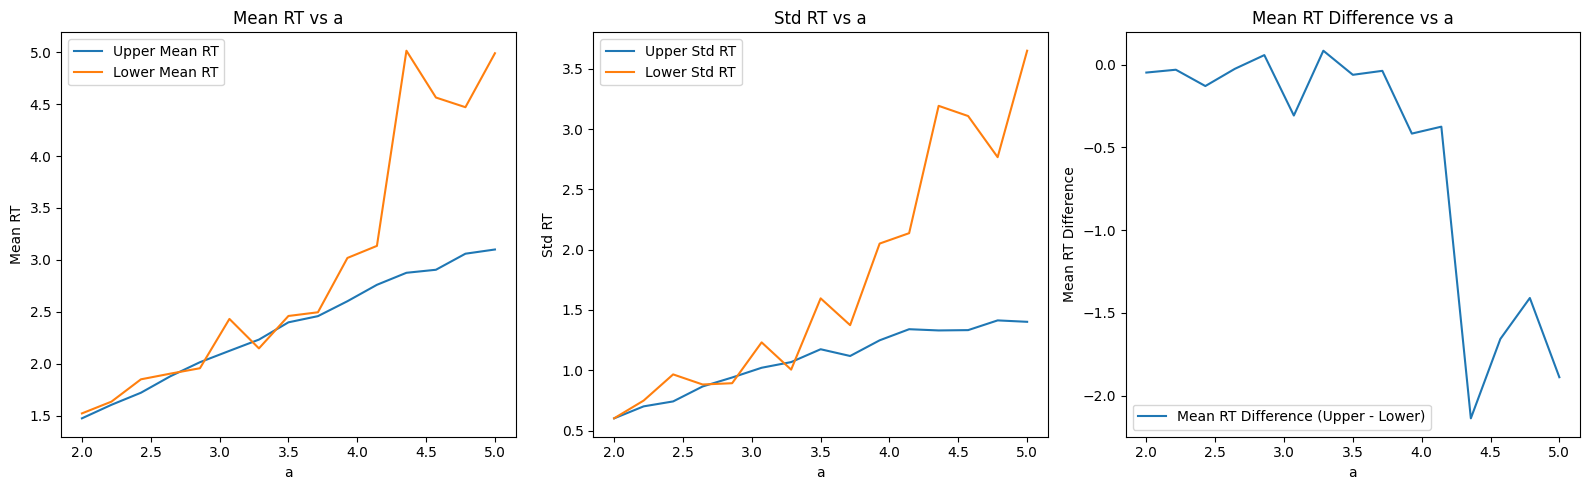

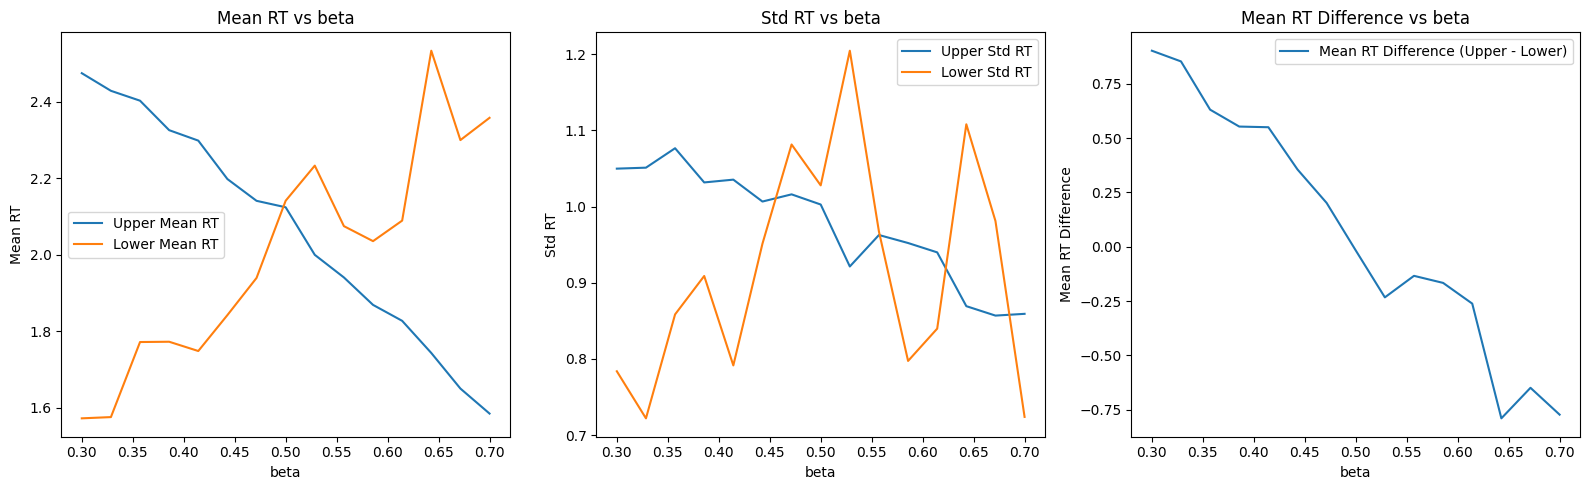

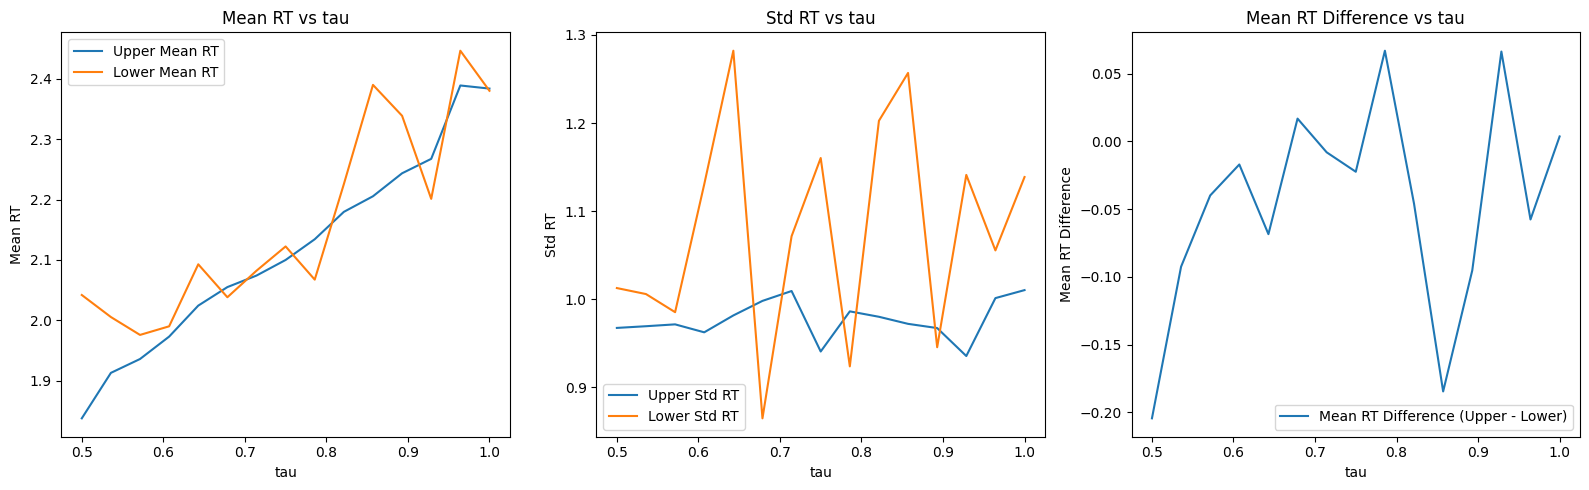

In [105]:
# Analyzing the effect of each parameter
fixed_params = {'v': 1, 'a': 3, 'beta': 0.5, 'tau': 0.7}
a_range = np.linspace(2, 5, 15)
beta_range = np.linspace(0.3, 0.7, 15)
tau_range = np.linspace(0.5, 1.0, 15)

a_stats = analyze_parameter_impact_on_rts(a_range, 'a', fixed_params)
beta_stats = analyze_parameter_impact_on_rts(beta_range, 'beta', fixed_params)
tau_stats = analyze_parameter_impact_on_rts(tau_range, 'tau', fixed_params)


# Plotting the statistics for each parameter
plot_stats(a_range, a_stats, 'a')
plot_stats(beta_range, beta_stats, 'beta')
plot_stats(tau_range, tau_stats, 'tau')

#### Effect of Boundary Separation (`a`)
- **Mean RTs**: The graphs indicate that as the boundary separation `a` increases, mean response times for the upper boundary show an increasing trend, while the lower boundary mean RTs also experience an increasing trend that is more dramatic at larger values of `a`. The lower bound evidently has a greater mean RT as displayed in the difference graph.
- **Standard Deviations**: The standard deviation for both boundaries generally increases with `a`. The sharp increase at higher values of `a` for the lower boundary could be indicative of increased decision difficulty, leading to more variability in the response times as the threshold is set higher.

#### Effect of Prior Preference (`beta`)
- **Mean RTs**: For the prior preference `beta`, we see a decrease in mean RT for the upper boundary as `beta` increases, which aligns with the model starting closer to the upper boundary and thus reaching it more quickly. The lower boundary's mean RT increases, indicating the opposite. The lower bound evidently has a greater mean RT as displayed in the difference graph.
- **Standard Deviations**: The standard deviation for the lower boundary varies significantly, suggesting that the proximity of the starting point to the upper boundary introduces unpredictability in reaching the lower boundary. This effect is less pronounced for the upper boundary, which might be due to it being the favored boundary as `beta` increases.

#### Effect of Non-Decision Time (`tau`)
- **Mean RTs**: The mean response times for both the upper and lower boundaries initially fluctuate as `tau` increases, and then both maintain a general upward trend.
- **Standard Deviations**: The standard deviation for both boundaries shows considerable variability as `tau` increases. However, the lower boundary definitely varies more. Notably, there is a peak in the standard deviation for the lower boundary, which could be indicative of specific `tau` values where the model's outcomes become more unpredictable. The overall variability suggests that the non-decision time contributes to the randomness in the decision-making process, affecting the consistency of the response times. Although, we cannot determine any specific trend from the data in one direction.
